In [1]:
import pickle 
import numpy as np

In [2]:
with open('train_qa.txt','rb') as f:
    train_data=pickle.load(f)

In [3]:
with open('test_qa.txt','rb') as f:
    test_data=pickle.load(f)

In [4]:
type(test_data)

list

In [6]:
len(train_data)

10000

In [7]:
len(test_data)

1000

In [10]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [16]:
print(' '.join(train_data[0][0]))
print(' '.join(train_data[0][1]))
print(''.join(train_data[0][2]))

Mary moved to the bathroom . Sandra journeyed to the bedroom .
Is Sandra in the hallway ?
no


In [17]:
all_data=test_data+train_data

In [19]:
vocab=set()

for story,question,answer in all_data:
    vocab=vocab.union(set(story))
    vocab=vocab.union(set(question))

In [20]:
vocab.add('no')
vocab.add('yes')

In [22]:
len(vocab)

37

In [23]:
vocab_len=len(vocab)+1

In [30]:
#LONGEST STORY
all_story_len=[len(data[0]) for data in all_data]

In [31]:
max_story_len=max(all_story_len)

In [32]:
#LONGEST QUESTION
all_ques_len=[len(data[1]) for data in all_data]

In [33]:
max_ques_len=max(all_ques_len)

In [35]:
max_story_len

156

# -------------------------------------------------------

In [37]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [40]:
tokenizer=Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [41]:
tokenizer.word_index

{'john': 1,
 'dropped': 2,
 '.': 3,
 'yes': 4,
 'put': 5,
 'left': 6,
 'up': 7,
 'the': 8,
 'took': 9,
 '?': 10,
 'daniel': 11,
 'kitchen': 12,
 'there': 13,
 'to': 14,
 'bathroom': 15,
 'journeyed': 16,
 'went': 17,
 'grabbed': 18,
 'moved': 19,
 'no': 20,
 'milk': 21,
 'office': 22,
 'football': 23,
 'apple': 24,
 'hallway': 25,
 'down': 26,
 'is': 27,
 'back': 28,
 'bedroom': 29,
 'in': 30,
 'garden': 31,
 'got': 32,
 'picked': 33,
 'travelled': 34,
 'discarded': 35,
 'mary': 36,
 'sandra': 37}

In [42]:
train_story_text=[]
train_ques_text=[]
train_ans_text=[]

In [43]:
for story,ques,ans in train_data:
    train_story_text.append(story)
    train_ques_text.append(ques)
    train_ans_text.append(ans)

In [45]:
train_story_seq=tokenizer.texts_to_sequences(train_story_text)

In [47]:
def vectorize_story(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_ques_len=max_ques_len):
    
    #stories
    X=[]
    #Questions
    Xq=[]
    #Answers
    Y=[]
    
    for story,question,answer in data:
        
        #for each story
        #[23,14,....]
        x=[word_index[word.lower()] for word in story]
        xq=[word_index[word.lower()] for word in question]
        
        y=np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_ques_len),np.array(Y))
        

In [50]:
inputs_train,queries_train,answers_train=vectorize_story(train_data)

In [51]:
inputs_test,queries_test,answers_test=vectorize_story(test_data)

In [53]:
queries_train

array([[27, 37, 30,  8, 25, 10],
       [27, 11, 30,  8, 15, 10],
       [27, 11, 30,  8, 22, 10],
       ...,
       [27, 37, 30,  8, 25, 10],
       [27, 36, 30,  8, 12, 10],
       [27, 36, 30,  8, 29, 10]], dtype=int32)


# -------------------------------------

In [54]:
from keras.models import Sequential,Model
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [55]:
#place holder shape = (max_story_len,batch_size)
input_sequence=Input((max_story_len,))
question=Input((max_ques_len,))

In [56]:
#vocab len
vocab_size=len(vocab)+1

In [64]:
# INPUT ENCODER M
input_encoder_m=Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

#OUTPUT -
# (samples,story_len,embedding_dim)

In [65]:
# INPUT ENCODER C
input_encoder_c=Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_ques_len))
input_encoder_c.add(Dropout(0.3))

#OUTPUT - 
#(samples,story_len,embedding_dim)

In [66]:
question_encoder=Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_ques_len))
question_encoder.add(Dropout(0.3))

#(samples,query_max_len,embedding_dim)

In [67]:
#ENCODED <----- ENCODER(INPUT)
input_encoded_m=input_encoder_m(input_sequence)
input_encoded_c=input_encoder_c(input_sequence)
question_encoded=question_encoder(question)

In [69]:
match=dot([input_encoded_m,question_encoded],axes=(2,2))
match=Activation('softmax')(match)

In [71]:
response=add([match,input_encoded_c])
response=Permute((2,1))(response)

In [72]:
answer=concatenate([response,question_encoded])

In [73]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [74]:
answer=LSTM(32)(answer)

In [75]:
answer=Dropout(0.5)(answer)
answer=Dense(vocab_size)(answer)  #  (samples,vocab_Size)  #YES/NO 0000

In [76]:
answer=Activation('softmax')(answer)

In [77]:
model=Model([input_sequence,question],answer)

In [89]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

# ---------------------------------------------

In [133]:
history=model.fit([inputs_train,queries_train],answers_train,batch_size=32,epochs=5,
                  validation_data=([inputs_test,queries_test],answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/5
10000/10000 [==============================] - 4s 377us/step - loss: 1.5333 - accuracy: 0.4537 - val_loss: 0.6956 - val_accuracy: 0.4970
Epoch 2/5
10000/10000 [==============================] - 4s 381us/step - loss: 0.6990 - accuracy: 0.5229 - val_loss: 0.6863 - val_accuracy: 0.5470
Epoch 3/5
10000/10000 [==============================] - 4s 372us/step - loss: 0.6861 - accuracy: 0.5423 - val_loss: 0.6627 - val_accuracy: 0.5930
Epoch 4/5
10000/10000 [==============================] - 4s 385us/step - loss: 0.6598 - accuracy: 0.5861 - val_loss: 0.6257 - val_accuracy: 0.6200
Epoch 5/5
10000/10000 [==============================] - 4s 374us/step - loss: 0.6245 - accuracy: 0.6263 - val_loss: 0.5981 - val_accuracy: 0.6710


In [134]:
filename = 'chatbot_5_epochs.h5'
model.save(filename)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


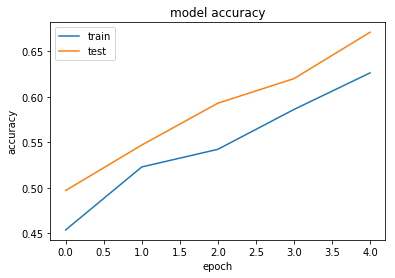

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [143]:
model.load_weights('chatbot_120_epochs.h5')

In [144]:
pred_results=model.predict(([inputs_test,queries_test]))

In [145]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [146]:
val_max=np.argmax(pred_results[0])

In [147]:
for key,val in tokenizer.word_index.items():
    if val==val_max:
        k=key

In [148]:
k

'moved'

In [149]:
pred_results[0][val_max]

0.6328979

In [150]:
my_story='John left the kitchen . Sandra dropped the football in the garden .'

In [151]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [152]:
my_question='is the football in the garden ?'

In [153]:
my_question.split()

['is', 'the', 'football', 'in', 'the', 'garden', '?']

In [154]:
mydata=[(my_story.split(),my_question.split(),'yes')]

In [155]:
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [156]:
my_story,my_ques,my_ans=vectorize_story(mydata)

In [158]:
pred_results=model.predict(([my_story,my_ques]))

In [159]:
val_max=np.argmax(pred_results[0])

In [160]:
for key,val in tokenizer.word_index.items():
    if val==val_max:
        k=key

In [161]:
k

'left'

In [162]:
pred_results[0][val_max]

0.88823766